In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

%matplotlib inline

rc('font', family='Malgun Gothic')
sns.set_style('whitegrid')

In [7]:
df = pd.read_csv("../ML Project/archive (1)/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [8]:
df_ohe = pd.get_dummies(df[['Geography', 'Gender']])
pre_ohe = df.drop(['Geography', 'Gender'], axis=1)
data = pd.concat([pre_ohe, df_ohe], axis=1)
columns_order = [col for col in data.columns if col != 'Exited']
data = data[columns_order + ['Exited']]
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,1,15634602,Hargrave,619,42.0,2,0.00,1,1.0,1.0,101348.88,True,False,False,True,False,1
1,2,15647311,Hill,608,41.0,1,83807.86,1,0.0,1.0,112542.58,False,False,True,True,False,0
2,3,15619304,Onio,502,42.0,8,159660.80,3,1.0,0.0,113931.57,True,False,False,True,False,1
3,4,15701354,Boni,699,39.0,1,0.00,2,0.0,0.0,93826.63,True,False,False,True,False,0
4,5,15737888,Mitchell,850,43.0,2,125510.82,1,NaN,1.0,79084.10,False,False,True,True,False,0


In [55]:
# Check for missing values and understand data types
missing_values = df.isnull().sum()
data_types = df.dtypes

missing_values, data_types

(RowNumber          0
 CustomerId         0
 Surname            0
 CreditScore        0
 Geography          1
 Gender             0
 Age                1
 Tenure             0
 Balance            0
 NumOfProducts      0
 HasCrCard          1
 IsActiveMember     1
 EstimatedSalary    0
 Exited             0
 dtype: int64,
 RowNumber            int64
 CustomerId           int64
 Surname             object
 CreditScore          int64
 Geography           object
 Gender              object
 Age                float64
 Tenure               int64
 Balance            float64
 NumOfProducts        int64
 HasCrCard          float64
 IsActiveMember     float64
 EstimatedSalary    float64
 Exited               int64
 dtype: object)

In [85]:
from sklearn.preprocessing import OneHotEncoder


df = df_data.copy()

categorical_columns = ['Geography', 'Gender']
one_hot_encoder = OneHotEncoder(sparse=False, drop='first') 
encoded_data = one_hot_encoder.fit_transform(df[categorical_columns])

encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names(categorical_columns))

C:\Users\hwkim\miniconda3\envs\ds_study\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [86]:
df = pd.concat([df.drop(categorical_columns, axis=1), encoded_df], axis=1)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Geography_nan,Gender_Male
0,1,15634602,Hargrave,619,42.0,2,0.00,1,1.0,1.0,101348.88,1,0.0,0.0,0.0,0.0
1,2,15647311,Hill,608,41.0,1,83807.86,1,0.0,1.0,112542.58,0,0.0,1.0,0.0,0.0
2,3,15619304,Onio,502,42.0,8,159660.80,3,1.0,0.0,113931.57,1,0.0,0.0,0.0,0.0
3,4,15701354,Boni,699,39.0,1,0.00,2,0.0,0.0,93826.63,0,0.0,0.0,0.0,0.0
4,5,15737888,Mitchell,850,43.0,2,125510.82,1,NaN,1.0,79084.10,0,0.0,1.0,0.0,0.0


In [72]:
# 결측치가 있는 행 삭제
data = data.dropna()

# X, y 분할
X = data.drop(['Exited', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=13)
X_ovr, y_ovr = smote.fit_resample(X_train, y_train)

In [88]:
if 'id' in data.columns:
    data = data.drop(['id'], axis=1)

X = data.drop(['Exited', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']

In [89]:
X = data.drop(['Exited', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=13)
X_ovr, y_ovr = smote.fit_resample(X_train, y_train)

In [90]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_ovr.shape, y_ovr.shape)

(7999, 14) (2000, 14) (7999,) (2000,)
(12700, 14) (12700,)


In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

def evaluate_model(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

evaluate_model(y_test, lr_pred, lr_proba[:, 1])

Accuracy: 0.80
Precision: 0.47
Recall: 0.08
F1 Score: 0.14
ROC AUC: 0.68
Confusion Matrix:
[[1576   35]
 [ 358   31]]


In [92]:
X = data.drop(['Exited', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=13)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [93]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.86
Precision: 0.67
Recall: 0.53
F1 Score: 0.59
ROC AUC: 0.84
Confusion Matrix:
[[1511  100]
 [ 182  207]]


In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_test, lgb_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, lgb_pred)
print("Precision:", precision)

recall = recall_score(y_test, lgb_pred)
print("Recall:", recall)

f1 = f1_score(y_test, lgb_pred)
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, lgb_proba[:, 1])
print("ROC AUC:", roc_auc)

confusion = confusion_matrix(y_test, lgb_pred)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.857
Precision: 0.6634920634920635
Recall: 0.5372750642673522
F1 Score: 0.59375
ROC AUC: 0.8641026745750215
Confusion Matrix:
 [[1505  106]
 [ 180  209]]


In [95]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_ovr, y_ovr)

rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, rf_pred)
print("Precision:", precision)

recall = recall_score(y_test, rf_pred)
print("Recall:", recall)

f1 = f1_score(y_test, rf_pred)
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, rf_proba)
print("ROC AUC:", roc_auc)

confusion = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:\n", confusion)


Accuracy: 0.859
Precision: 0.6742671009771987
Recall: 0.532133676092545
F1 Score: 0.5948275862068966
ROC AUC: 0.8400672433574445
Confusion Matrix:
 [[1511  100]
 [ 182  207]]


In [98]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_ovr, y_ovr)

xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, xgb_pred)
print("Precision:", precision)

recall = recall_score(y_test, xgb_pred)
print("Recall:", recall)

f1 = f1_score(y_test, xgb_pred)
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, xgb_proba)
print("ROC AUC:", roc_auc)

confusion = confusion_matrix(y_test, xgb_pred)
print("Confusion Matrix:\n", confusion)


Accuracy: 0.8525
Precision: 0.6390532544378699
Recall: 0.5552699228791774
F1 Score: 0.594222833562586
ROC AUC: 0.8475870421699148
Confusion Matrix:
 [[1489  122]
 [ 173  216]]


In [100]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_ovr, y_ovr)

rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, rf_pred)
print("Precision:", precision)

recall = recall_score(y_test, rf_pred)
print("Recall:", recall)

f1 = f1_score(y_test, rf_pred)
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, rf_proba)
print("ROC AUC:", roc_auc)

confusion = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:\n", confusion)


Accuracy: 0.859
Precision: 0.6742671009771987
Recall: 0.532133676092545
F1 Score: 0.5948275862068966
ROC AUC: 0.8400672433574445
Confusion Matrix:
 [[1511  100]
 [ 182  207]]


In [102]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_ovr, y_ovr)


catboost_pred = catboost_model.predict(X_test)
catboost_proba = catboost_model.predict_proba(X_test)[:, 1]

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_test, catboost_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, catboost_pred)
print("Precision:", precision)

recall = recall_score(y_test, catboost_pred)
print("Recall:", recall)

f1 = f1_score(y_test, catboost_pred)
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, catboost_proba)
print("ROC AUC:", roc_auc)

confusion = confusion_matrix(y_test, catboost_pred)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.859
Precision: 0.6666666666666666
Recall: 0.5501285347043702
F1 Score: 0.6028169014084507
ROC AUC: 0.8627048297453721
Confusion Matrix:
 [[1504  107]
 [ 175  214]]


In [104]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm_model = SVC(random_state=42)
svm_model.fit(X_ovr, y_ovr)

svm_pred = svm_model.predict(X_test)

print("SVM 모델 성능 평가:")
print(classification_report(y_test, svm_pred))

conf_matrix = confusion_matrix(y_test, svm_pred)
print("Confusion Matrix:")
print(conf_matrix)


SVM 모델 성능 평가:
              precision    recall  f1-score   support

           0       0.86      0.39      0.53      1611
           1       0.22      0.74      0.34       389

    accuracy                           0.45      2000
   macro avg       0.54      0.56      0.44      2000
weighted avg       0.73      0.45      0.50      2000

Confusion Matrix:
[[622 989]
 [103 286]]


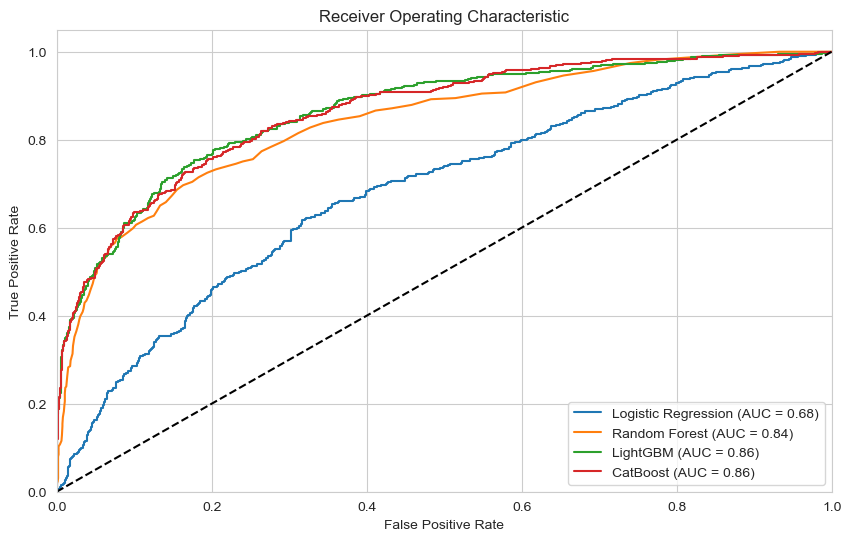

In [105]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

models = ["Logistic Regression", "Random Forest", "LightGBM", "CatBoost"]
probas = [lr_proba[:, 1], rf_proba, lgb_proba[:, 1], catboost_proba] 

plt.figure(figsize=(10, 6))
for i in range(len(models)):
    fpr, tpr, _ = roc_curve(y_test, probas[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{models[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


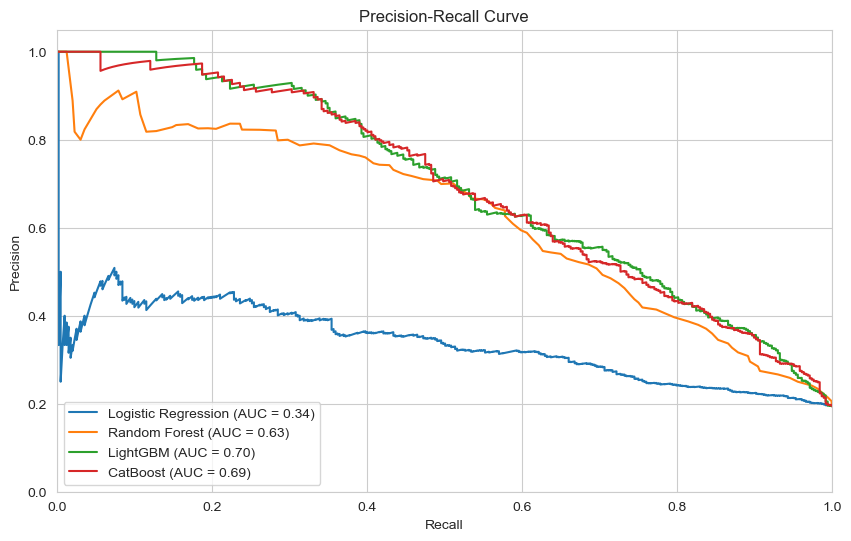

In [106]:
plt.figure(figsize=(10, 6))
for i in range(len(models)):
    precision, recall, _ = precision_recall_curve(y_test, probas[i])
    pr_auc = auc(recall, precision) 
    plt.plot(recall, precision, label=f'{models[i]} (AUC = {pr_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
